# Strategy to compute the second output given the first output

Observing the data we have notice that
1. The outputs of the ML cup are strongly correlated.
2. One of the two output is really easy to learn ('cause is linear with some input).

With this two assumption one could try to learn the second output after the learning of the first output with various methods 

In [1]:
%matplotlib inline
#project_dir = '../../'
project_dir = 'ML/'

data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split,Normalize
from scipy.optimize import curve_fit
from utils.losses import MEE

In [168]:
def plot_results(network, input_data, val_data, 
                 labels, val_labels, func = None, func_args = None):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    if func!=None:
        fitted_out_train = func(train_pred[:,-1], *func_args)
        #train_pred[:, 0] = fitted_out_train
        train_pred[:, 0] = (train_pred[:,0] + fitted_out_train)/2
        
        fitted_out_val = func(val_pred[:,-1], *func_args)
        #val_pred[:, 0] = fitted_out_val
        val_pred[:, 0] = (val_pred[:,0] + fitted_out_val)/2

    
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    for i in range(labels.shape[1]):
        plt.plot(np.arange(len(labels)),labels[:,i]-train_pred[:,i],".",label=f"residual{i}")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    for i in range(val_labels.shape[1]):
        plt.plot(np.arange(len(val_labels)),val_labels[:,i]-val_pred[:,i],".",label=f"residual{i}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print('final train error:', MEE(labels, train_pred))
    print('final val error:', MEE(val_labels, val_pred))

## Importing data

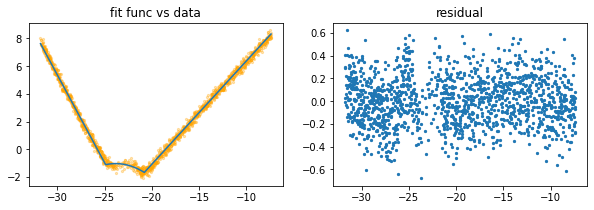

RMS = 8.204114079624075 (root sum of squared residual)


In [17]:
raw_data=np.loadtxt(data_dir + "TR.csv",delimiter=",")[:,1:]
np.random.shuffle(raw_data)
other_output=raw_data[:,10]
lin_output=raw_data[:,11]
x = np.copy(lin_output)

x1 = np.copy(lin_output)
y1 = np.copy(other_output)

def parabola(x, a, b, c, stop1 = None, stop2 = None, stop = True):
    g = a * x*x + b * x + c # the parabola
    if stop: # Manual double heaviside
        g[x<stop1] = 0
        g[x>stop2] = 0
    return g

def linear(x, m, stop, a, b, c, cut_left = True):
    # Compute q in a way to create a continuos function
    q = parabola(stop,  a, b, c, stop = False) - m * stop
    y = m*x + q # the linear function
    if cut_left: y[x<stop] = 0 # Manual left heaviside
    else: y[x>stop] = 0 # Manual right heaviside
    return y

def lin_para_lin(x, a, b, c, m1, stop1, m2, stop2):
    """
    Fit function create by hand:
    - on the left a linear function with angolar coefficient m1
    - on the middle a parabola ax^2 + bx + c
    - on the right another linear function with m2
    stop1 and stop2 are the two points where you switch from 
    linear1->parabola and parabola->linear 2 (with continuity).
    NOTE: the intercept q of the linear function are fixed for the 
          continuity.
    """
    return linear(x, m1, stop1, a, b, c, cut_left = False) +\
           parabola(x, a, b, c, stop1, stop2) +\
           linear(x, m2, stop2,  a, b, c, cut_left = True)

# Parabola parameters in order to catch the maximum [ wikipedia formula :( ] 
c = -100
x_v = -23
y_v = 0

# Linear parameters: m and stop
lin_params1 = (-1, -24)
lin_params2 = (0.8, -21)


a = (y_v + c)/(x_v**2)
b = -2 * a * x_v 
parabola_params = (a, b, c)


params = (*parabola_params, *lin_params1, *lin_params2)
popt_para,pcov=curve_fit(lin_para_lin,x1, y1, p0=params)
xx = np.linspace(np.min(x), np.max(x), 1000)
fig, axs = plt.subplots(1, 2, figsize = (10, 3))
axs[0].plot(xx,lin_para_lin(xx,*popt_para))
axs[0].scatter(x1, y1, s = 5, label ='real', alpha = 0.3, c='orange')
axs[0].set_title('fit func vs data')
axs[1].scatter(x1, y1-lin_para_lin(x1,*popt_para), s = 5)
axs[1].set_title('residual')
plt.show()
RMS = np.sqrt(np.sum((y1-lin_para_lin(x1,*popt_para))**2))
print(f'RMS = {RMS} (root sum of squared residual)')

## Fit with sinusoidal + line

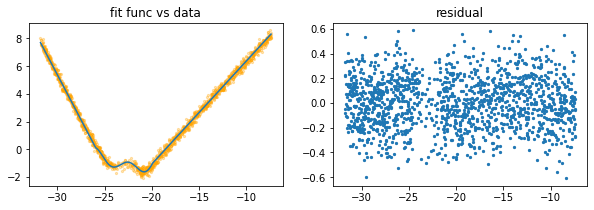

RMS = 7.923883011671895 (root sum of squared residual)


In [21]:
raw_data=np.loadtxt(data_dir + "TR.csv",delimiter=",")[:,1:]
np.random.shuffle(raw_data)
other_output=raw_data[:,10]
lin_output=raw_data[:,11]
x = np.copy(lin_output)

x1 = np.copy(lin_output)
y1 = np.copy(other_output)

def sinusoidal(x, a, w, phi, shift, m, q, stop1 = None, stop2 = None, stop = True):
    l = linear1(x, m, None, q0 = q)
    g = a*l*np.sin(w*x + phi) + shift # the parabola
    if stop: # Manual double heaviside
        g[x<stop1] = 0
        g[x>stop2] = 0
    return g

def linear1(x, m, func, *func_args, stop_left = None, stop_right = None,
           cut_left = False, cut_right = False, q0 = None):
    # Compute q in a way to create a continuos function
    if cut_left: 
        q = func(stop_left, *func_args, stop = False) - m * stop_left
    elif cut_right: 
        q = func(stop_right, *func_args, stop = False) - m * stop_right
    else: q = q0
    y = m*x + q # the linear function
    if cut_left: y[x<stop_left] = 0 # Manual left heaviside
    if cut_right: y[x>stop_right] = 0 # Manual right heaviside
    return y

def lin_sin_lin(x, a, w, phi, shift, m, q, m1, stop1, m2, stop2):
    """
    Fit function create by hand:
    - on the left a linear function with angolar coefficient m1
    - on the middle a sinusoid
    - on the right another linear function with m2
    stop1 and stop2 are the two points where you switch from 
    linear1->parabola and parabola->linear 2 (with continuity).
    NOTE: the intercept q of the linear function are fixed for the 
          continuity.
    """
    func = sinusoidal
    func_args = (a, w, phi, shift, m, q,)
    return linear1(x, m1, func, *func_args, stop_right = stop1, cut_right = True) +\
           func(x, *func_args, stop1, stop2) +\
           linear1(x, m2, func, *func_args, stop_left = stop2, cut_left = True)

a = 0.4   
w = 1.3  
phi = -1.8
shift = -1

# Linear parameters: m and stop
lin_params1 = (-1.3, -26)
lin_params2 = ( 0.7, -20)
sin_params = (a, w, phi, shift, -0.89,-20.)

params = (*sin_params, *lin_params1, *lin_params2)
popt_sin,pcov=curve_fit(lin_sin_lin,x1, y1, p0=params, maxfev=5000)
xx = np.linspace(np.min(x), np.max(x), 1000)
fig, axs = plt.subplots(1, 2, figsize = (10, 3))
axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
axs[0].scatter(x1, y1, s = 5, label ='real', alpha = 0.3, c='orange')
axs[0].set_title('fit func vs data')
axs[1].scatter(x1, y1-lin_sin_lin(x1,*popt_sin), s = 5)
axs[1].set_title('residual')
plt.show()
RMS = np.sqrt(np.sum((y1-lin_sin_lin(x1,*popt_sin))**2))
print(f'RMS = {RMS} (root sum of squared residual)')

In [213]:
new_data = np.copy(raw_data)
input_data=new_data[:,:-2]
input_labels=new_data[:,-2:]

#.reshape((len(raw_data), 1))

frac_test=0.15
data, test_set, labels, test_labels = split(input_data, input_labels, 
                                            kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
training, validation, labels, val_labels=split(data, labels,kind="hold_out",
                                                   frac_training=frac_training)

In [207]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

In [210]:
structure=[20,np.shape(labels)[1]]
act_func=["sigmoid"]*(len(structure)-1)+["linear"]
start=xavier(structure)

netw = MLP(structure, func=act_func,
           starting_points=start)

In [211]:
N_epoch = 20000
lamb=1e-4
batch_size = -1 #-1 for batch gradient descent
alpha=5e-1
nesterov=True
eta_function=1e-3
beta=0.9
netw.train(training, labels, validation, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta =eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta, 
           error_threshold = 0., patience = 30)

Epoch 3520:  [train MEE = 1.0182]  [val MEE = 1.1279]                              
Elapsed time: 8.609951734542847 s


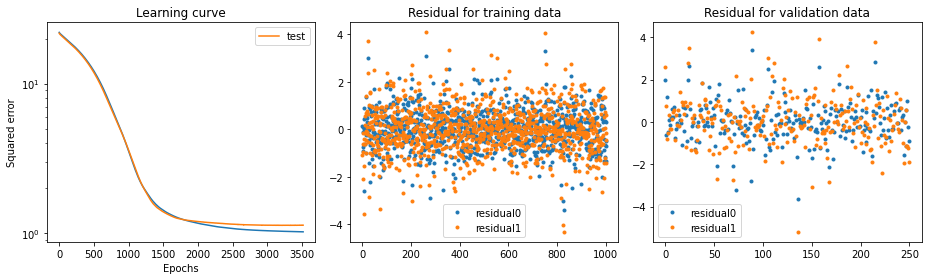

final train error: 0.9909959792011885
final val error: 1.115699315145055


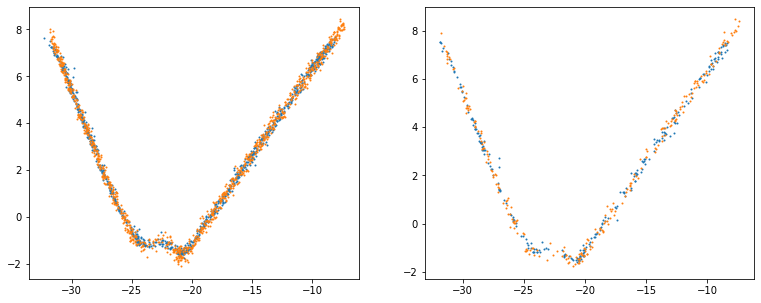

In [217]:
# Check scores
func = lin_sin_lin ; func_args = popt_sin
plot_results(netw, training, validation, labels, 
             val_labels, func = func, func_args = func_args)

# Check similarity
train_pred = netw.predict(training)
val_pred = netw.predict(validation)

fitted_out_train = func(train_pred[:,-1], *func_args)
#train_pred[:, 0] = fitted_out_train
train_pred[:, 0] = (train_pred[:,0] + fitted_out_train)/2

fitted_out_val = func(val_pred[:,-1], *func_args)
#val_pred[:, 0] = fitted_out_val
val_pred[:, 0] = (val_pred[:,0] + fitted_out_val)/2

fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.scatter(train_pred[:,1], train_pred[:,0], s = 1)
plt.scatter(labels[:,1], labels[:,0], s = 1)
plt.subplot(122)
plt.scatter(val_pred[:,1], val_pred[:,0], s = 1)
plt.scatter(val_labels[:,1], val_labels[:,0], s = 1)
plt.show()